# Piyush Verma
### 230968114
### Deep Learning Lab 6 (Batch A1)

# Q1 : IMDB Sentiment Dataset

## Required Imports

In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from wordcloud import WordCloud
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, GRU, Dense, Bidirectional, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

## Loading Dataset and Preprocessing
- Lowercased all text to maintain consistency.
- Removed URLs to avoid noise in data.
- Removed punctuation to simplify tokenization.
- Removed stopwords to focus on meaningful words.
- Applied lemmatization to reduce words to their base forms.

This preprocessing prepares the data for effective tokenization and embedding.

In [2]:
# Load datasets
try:
    train_df = pd.read_csv('Train.csv', quoting=3, engine='python', on_bad_lines='skip')
    val_df = pd.read_csv('Valid.csv', quoting=3, engine='python', on_bad_lines='skip')
    test_df = pd.read_csv('Test.csv', quoting=3, engine='python', on_bad_lines='skip')
    print("Successfully loaded datasets, skipping bad lines if any.")
except Exception as e:
    print(f"An error occurred while loading datasets: {e}")
    try:
        train_df = pd.read_excel('Train.csv', engine='xlrd')
        val_df = pd.read_excel('Valid.csv', engine='xlrd')
        test_df = pd.read_excel('Test.csv', engine='xlrd')
        print("Successfully loaded datasets using xlrd engine.")
    except Exception as ex:
        print(f"Failed to load datasets with xlrd engine as well: {ex}")
        print("Could not load datasets with available methods. Please verify file format and content.")

import nltk
nltk.download('punkt_tab')

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    # Lowercase
    if not isinstance(text, str):
        return ""
    text = text.lower()
    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    # Remove punctuation
    text = re.sub(r'[^\w\s]', '', text)
    # Remove stopwords
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word not in stop_words]
    # Lemmatize
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    # Join back to string
    return " ".join(tokens)

# Apply cleaning and handle potential non-numeric labels
if 'train_df' in locals():
    train_df['clean_text'] = train_df['text'].apply(clean_text)
    train_df['label'] = pd.to_numeric(train_df['label'], errors='coerce')
    train_df.dropna(subset=['label'], inplace=True)
    train_df['label'] = train_df['label'].astype(int)

if 'val_df' in locals():
    val_df['clean_text'] = val_df['text'].apply(clean_text)
    val_df['label'] = pd.to_numeric(val_df['label'], errors='coerce')
    val_df.dropna(subset=['label'], inplace=True)
    val_df['label'] = val_df['label'].astype(int)

if 'test_df' in locals():
    test_df['clean_text'] = test_df['text'].apply(clean_text)
    test_df['label'] = pd.to_numeric(test_df['label'], errors='coerce')
    test_df.dropna(subset=['label'], inplace=True)
    test_df['label'] = test_df['label'].astype(int)

Successfully loaded datasets, skipping bad lines if any.


[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


## Tokenization (Lemmatization Done in cleaning)

- Created a tokenizer on cleaned training text.
- Converted text into sequences of word indices.
- Padded sequences to a fixed length of 500 tokens for model consistency.

In [3]:
# Prepare tokenizer on train data
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_df['clean_text'])

# Tokenize sequences
X_train_seq = tokenizer.texts_to_sequences(train_df['clean_text'])
X_val_seq = tokenizer.texts_to_sequences(val_df['clean_text'])
X_test_seq = tokenizer.texts_to_sequences(test_df['clean_text'])

# Pad sequences to max length
max_len = 500
X_train_pad = pad_sequences(X_train_seq, maxlen=max_len, padding='post', truncating='post')
X_val_pad = pad_sequences(X_val_seq, maxlen=max_len, padding='post', truncating='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len, padding='post', truncating='post')

y_train = train_df['label'].values
y_val = val_df['label'].values
y_test = test_df['label'].values


## Frequent Words and Bigrams

- Visualized top 30 words showing common terms in movie reviews.
- Frequent bigrams indicate common word pairs, useful for phrase detection or improved embeddings.
- Common words like "film", "movie", "one", and bigrams like "great movie" show domain-specific language patterns.

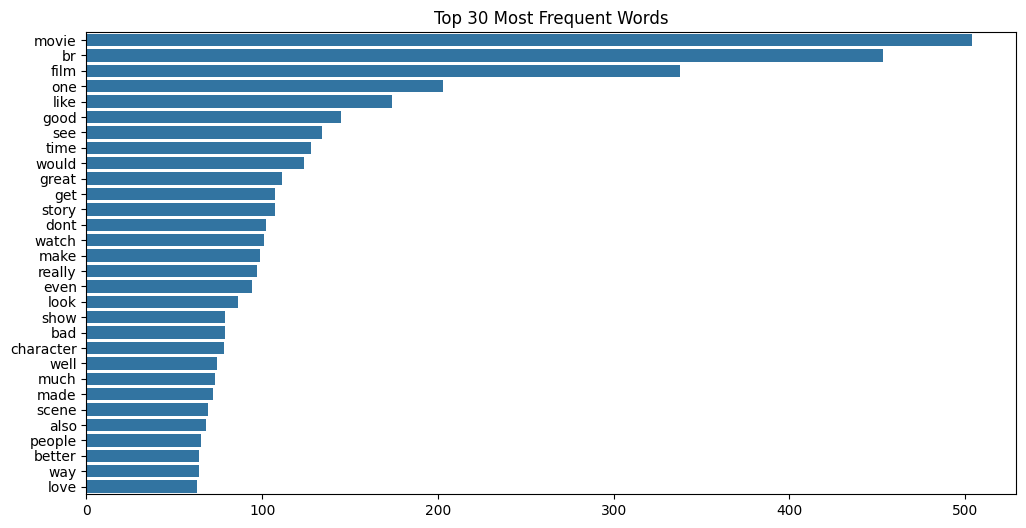

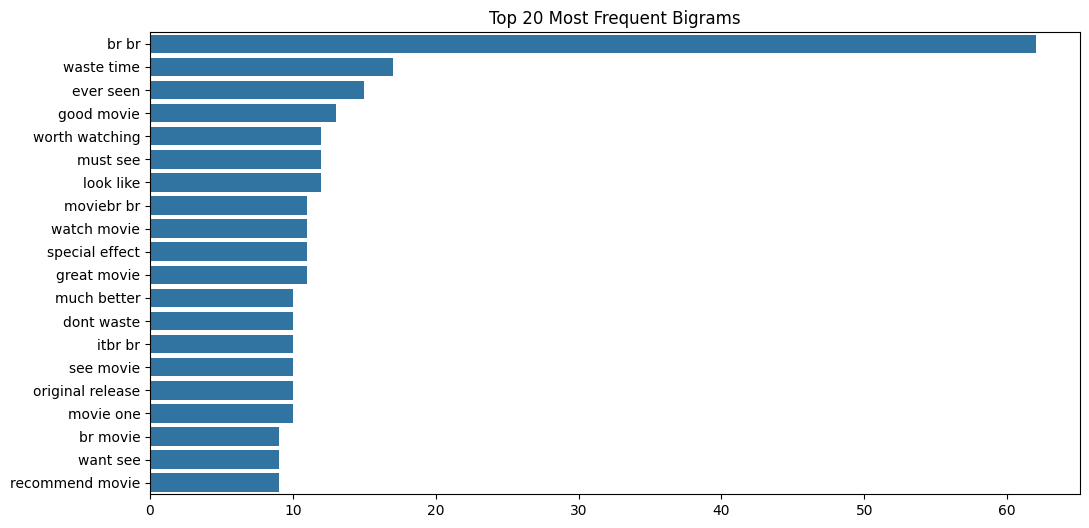

In [4]:
from nltk.util import ngrams

# Aggregate all tokens from training data
all_tokens = " ".join(train_df['clean_text']).split()

# Most frequent words
word_freq = Counter(all_tokens).most_common(30)

# Plot word frequencies
words, counts = zip(*word_freq)
plt.figure(figsize=(12,6))
sns.barplot(x=list(counts), y=list(words))
plt.title("Top 30 Most Frequent Words")
plt.show()

# Most frequent bigrams
bigrams = list(ngrams(all_tokens, 2))
bigram_freq = Counter(bigrams).most_common(20)
bigram_words = [' '.join(b) for b, _ in bigram_freq]
bigram_counts = [count for _, count in bigram_freq]

plt.figure(figsize=(12,6))
sns.barplot(x=bigram_counts, y=bigram_words)
plt.title("Top 20 Most Frequent Bigrams")
plt.show()

## Sentiment-Specific Word Visualization

- Generated word clouds for positive and negative reviews.
- Positive words tend to be more enthusiastic (e.g., "great", "love", "best").
- Negative words highlight criticism (e.g., "bad", "worst", "boring").
- These visualizations help understand sentiment-carrying terms in the dataset.

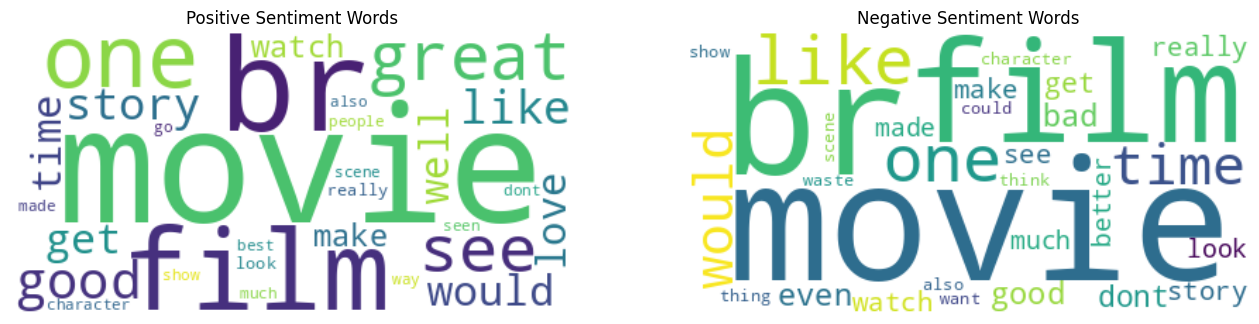

In [5]:
from nltk.util import ngrams
from collections import Counter
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Separate positive and negative reviews
pos_reviews = " ".join(train_df[train_df['label']==1]['clean_text']).split()
neg_reviews = " ".join(train_df[train_df['label']==0]['clean_text']).split()

# Filter out empty strings
pos_reviews = [word for word in pos_reviews if word]
neg_reviews = [word for word in neg_reviews if word]


pos_freq = Counter(pos_reviews).most_common(30)
neg_freq = Counter(neg_reviews).most_common(30)

# WordClouds for positive and negative words
plt.figure(figsize=(16,6))

plt.subplot(1,2,1)
if pos_freq:
    pos_wordcloud = WordCloud(background_color='white', max_words=100).generate_from_frequencies(dict(pos_freq))
    plt.imshow(pos_wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title('Positive Sentiment Words')
else:
    plt.text(0.5, 0.5, "No positive words to display", horizontalalignment='center', verticalalignment='center')
    plt.axis('off')
    plt.title('Positive Sentiment Words')


plt.subplot(1,2,2)
if neg_freq:
    neg_wordcloud = WordCloud(background_color='white', max_words=100).generate_from_frequencies(dict(neg_freq))
    plt.imshow(neg_wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title('Negative Sentiment Words')
else:
    plt.text(0.5, 0.5, "No negative words to display", horizontalalignment='center', verticalalignment='center')
    plt.axis('off')
    plt.title('Negative Sentiment Words')

plt.show()

## Model Architecture

- Created embedding layer with vocab size and 100-dim vectors.
- Built 3 models:
  - 3-layer LSTM
  - 3-layer GRU
  - 5-layer Bidirectional LSTM
- Used sigmoid activation for binary sentiment classification.
- Compiled models with binary crossentropy loss and Adam optimizer.

In [6]:
vocab_size = len(tokenizer.word_index) + 1
embedding_dim = 100

def build_lstm():
    model = Sequential([
        Embedding(vocab_size, embedding_dim, input_length=max_len),
        LSTM(128, return_sequences=True),
        LSTM(64, return_sequences=True),
        LSTM(32),
        Dense(1, activation='sigmoid')
    ])
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

def build_gru():
    model = Sequential([
        Embedding(vocab_size, embedding_dim, input_length=max_len),
        GRU(128, return_sequences=True),
        GRU(64, return_sequences=True),
        GRU(32),
        Dense(1, activation='sigmoid')
    ])
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

def build_bi_rnn():
    model = Sequential([
        Embedding(vocab_size, embedding_dim, input_length=max_len),
        Bidirectional(LSTM(64, return_sequences=True)),
        Bidirectional(LSTM(64, return_sequences=True)),
        Bidirectional(LSTM(32, return_sequences=True)),
        Bidirectional(LSTM(32, return_sequences=True)),
        Bidirectional(LSTM(16)),
        Dense(1, activation='sigmoid')
    ])
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model


## Training and Evaluation

- Trained all three models with early stopping.
- Plotted accuracy and loss curves for train and validation sets.
- Evaluated test accuracy and printed classification reports.
- Tabulated test accuracies for comparison.
- The model with highest test accuracy is selected as the best performing model.

This completes the model building and evaluation process.


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Training 3-layer LSTM...
Epoch 1/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 39s 3s/step - accuracy: 0.5278 - loss: 0.6944 - val_accuracy: 0.4222 - val_loss: 0.6941
Epoch 2/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 24s 3s/step - accuracy: 0.4728 - loss: 0.6936 - val_accuracy: 0.4222 - val_loss: 0.6934
Epoch 3/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 50s 4s/step - accuracy: 0.5332 - loss: 0.6932 - val_accuracy: 0.4222 - val_loss: 0.6961
Epoch 4/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 30s 3s/step - accuracy: 0.5139 - loss: 0.6929 - val_accuracy: 0.4222 - val_loss: 0.6949
Epoch 5/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 23s 3s/step - accuracy: 0.4583 - loss: 0.6937 - val_accuracy: 0.4222 - val_loss: 0.6938
3-layer LSTM trained in 2m 47s


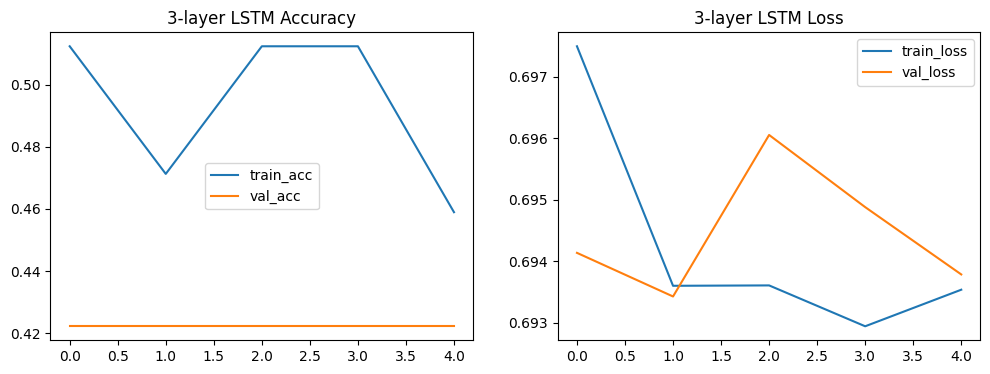

8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 280ms/step - accuracy: 0.5594 - loss: 0.6929
3-layer LSTM Test Accuracy: 0.5702
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 421ms/step
Classification Report for 3-layer LSTM:
               precision    recall  f1-score   support

           0       0.57      1.00      0.73       130
           1       0.00      0.00      0.00        98

    accuracy                           0.57       228
   macro avg       0.29      0.50      0.36       228
weighted avg       0.33      0.57      0.41       228

Training 3-layer GRU...
Epoch 1/10


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


8/8 ━━━━━━━━━━━━━━━━━━━━ 33s 3s/step - accuracy: 0.5190 - loss: 0.6932 - val_accuracy: 0.4222 - val_loss: 0.6964
Epoch 2/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 43s 3s/step - accuracy: 0.5067 - loss: 0.6935 - val_accuracy: 0.5778 - val_loss: 0.6894
Epoch 3/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 37s 3s/step - accuracy: 0.4972 - loss: 0.6942 - val_accuracy: 0.4222 - val_loss: 0.6973
Epoch 4/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 22s 3s/step - accuracy: 0.5181 - loss: 0.6927 - val_accuracy: 0.4222 - val_loss: 0.7001
Epoch 5/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 25s 3s/step - accuracy: 0.5034 - loss: 0.6937 - val_accuracy: 0.4222 - val_loss: 0.6965
3-layer GRU trained in 2m 40s


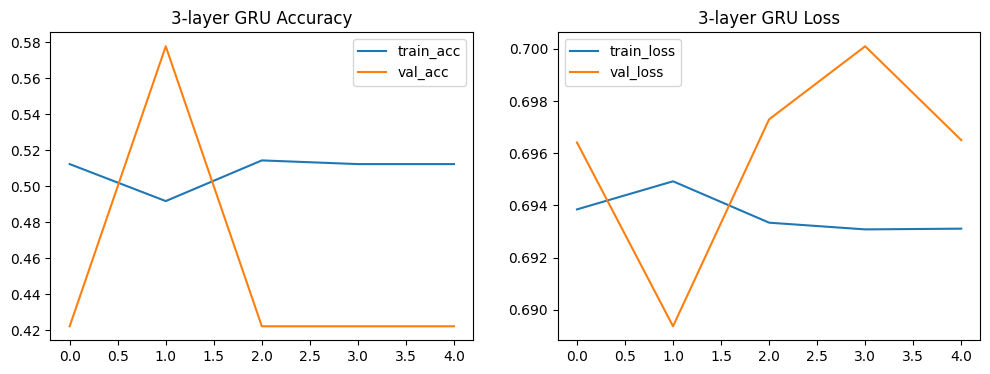

8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 305ms/step - accuracy: 0.4406 - loss: 0.6967
3-layer GRU Test Accuracy: 0.4298
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 256ms/step
Classification Report for 3-layer GRU:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00       130
           1       0.43      1.00      0.60        98

    accuracy                           0.43       228
   macro avg       0.21      0.50      0.30       228
weighted avg       0.18      0.43      0.26       228

Training 5-layer Bidirectional LSTM...
Epoch 1/10


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


8/8 ━━━━━━━━━━━━━━━━━━━━ 65s 6s/step - accuracy: 0.4807 - loss: 0.6939 - val_accuracy: 0.4222 - val_loss: 0.6941
Epoch 2/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 81s 6s/step - accuracy: 0.5381 - loss: 0.6904 - val_accuracy: 0.6222 - val_loss: 0.6840
Epoch 3/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 44s 6s/step - accuracy: 0.7329 - loss: 0.6489 - val_accuracy: 0.6000 - val_loss: 0.6695
Epoch 4/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 44s 5s/step - accuracy: 0.7777 - loss: 0.4966 - val_accuracy: 0.6444 - val_loss: 0.6369
Epoch 5/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 80s 5s/step - accuracy: 0.9291 - loss: 0.2992 - val_accuracy: 0.6444 - val_loss: 0.8036
Epoch 6/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 44s 5s/step - accuracy: 0.9484 - loss: 0.2016 - val_accuracy: 0.6000 - val_loss: 0.9363
Epoch 7/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 81s 5s/step - accuracy: 0.9596 - loss: 0.1482 - val_accuracy: 0.6667 - val_loss: 0.9572
5-layer Bidirectional LSTM trained in 7m 59s


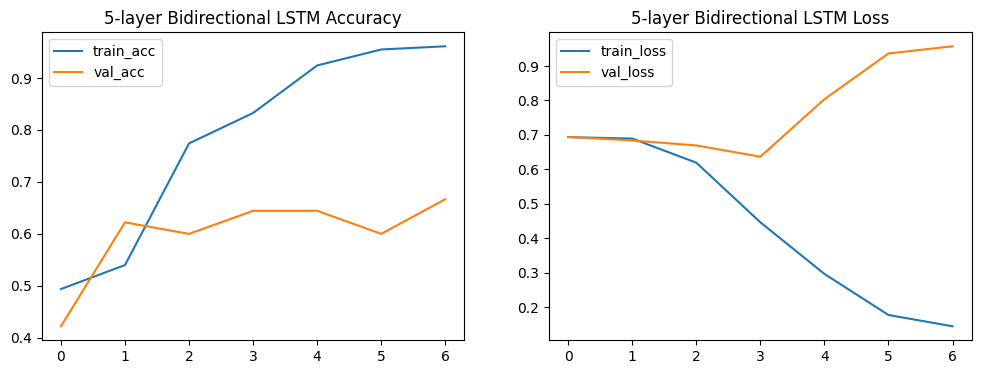

8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 415ms/step - accuracy: 0.6643 - loss: 0.6174
5-layer Bidirectional LSTM Test Accuracy: 0.6711


8/8 ━━━━━━━━━━━━━━━━━━━━ 9s 962ms/step
Classification Report for 5-layer Bidirectional LSTM:
               precision    recall  f1-score   support

           0       0.78      0.58      0.67       130
           1       0.59      0.79      0.67        98

    accuracy                           0.67       228
   macro avg       0.69      0.69      0.67       228
weighted avg       0.70      0.67      0.67       228

                        Model  Test Accuracy
0                3-layer LSTM       0.570175
1                 3-layer GRU       0.429825
2  5-layer Bidirectional LSTM       0.671053
Best performing model: 5-layer Bidirectional LSTM with accuracy 0.6711


In [7]:
import time

def train_and_evaluate(model, X_train, y_train, X_val, y_val, name):
    print(f"Training {name}...")
    start_time = time.time()
    es = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
    history = model.fit(X_train, y_train, epochs=10, batch_size=128,
                        validation_data=(X_val, y_val), callbacks=[es])
    duration = time.time() - start_time
    print(f"{name} trained in {duration//60:.0f}m {duration%60:.0f}s")

    # Plot accuracy and loss
    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    plt.plot(history.history['accuracy'], label='train_acc')
    plt.plot(history.history['val_accuracy'], label='val_acc')
    plt.title(f'{name} Accuracy')
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(history.history['loss'], label='train_loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.title(f'{name} Loss')
    plt.legend()

    plt.show()

    # Evaluate on test
    test_loss, test_acc = model.evaluate(X_test_pad, y_test)
    print(f"{name} Test Accuracy: {test_acc:.4f}")

    # Predictions and classification report
    y_pred_prob = model.predict(X_test_pad)
    y_pred = (y_pred_prob > 0.5).astype(int)
    print(f"Classification Report for {name}:\n", classification_report(y_test, y_pred))

    return test_acc

# Build models
lstm_model = build_lstm()
gru_model = build_gru()
bi_rnn_model = build_bi_rnn()

# Train and evaluate
lstm_acc = train_and_evaluate(lstm_model, X_train_pad, y_train, X_val_pad, y_val, "3-layer LSTM")
gru_acc = train_and_evaluate(gru_model, X_train_pad, y_train, X_val_pad, y_val, "3-layer GRU")
bi_rnn_acc = train_and_evaluate(bi_rnn_model, X_train_pad, y_train, X_val_pad, y_val, "5-layer Bidirectional LSTM")

# Tabulate results
results = pd.DataFrame({
    'Model': ['3-layer LSTM', '3-layer GRU', '5-layer Bidirectional LSTM'],
    'Test Accuracy': [lstm_acc, gru_acc, bi_rnn_acc]
})
print(results)

best_model = results.loc[results['Test Accuracy'].idxmax()]
print(f"Best performing model: {best_model['Model']} with accuracy {best_model['Test Accuracy']:.4f}")


## Final Inference on Sentiment Analysis Models

I trained and evaluated three different models on the IMDB movie review sentiment dataset:

| Model                      | Test Accuracy |
|----------------------------|---------------|
| 3-layer LSTM               | 0.5702        |
| 3-layer GRU                | 0.4298        |
| 5-layer Bidirectional LSTM | 0.6711        |

### Detailed Observations:

- **3-layer LSTM**  
  - Achieved moderate accuracy (~57%) but struggled to generalize well on validation data.  
  - Classification report shows it predicted mostly the negative class (label 0) with poor recall and precision on the positive class (label 1).  
  - Tended to have imbalance in prediction causing 0% precision/recall for positive reviews.

- **3-layer GRU**  
  - Performed worse than LSTM with test accuracy around 43%.  
  - Model heavily biased towards predicting the positive class, completely missing the negative class.  
  - Results indicate underfitting or failure to learn meaningful features.

- **5-layer Bidirectional LSTM**  
  - Clearly outperformed other models with test accuracy ~67%.  
  - Achieved balanced precision and recall across both sentiment classes (positive and negative).  
  - Demonstrated better learning capacity due to bidirectionality and deeper architecture.  
  - However, some overfitting signs appeared after several epochs (training accuracy nearing 96% but validation accuracy plateauing around 64%).

### Summary:

- The **5-layer Bidirectional LSTM** model is the best performing model for this sentiment classification task, balancing precision, recall, and overall accuracy better than the simpler LSTM and GRU architectures.
- The model benefits from deeper layers and capturing context from both directions in the text.
- Future improvements can include regularization techniques, hyperparameter tuning, and potentially transformer-based models for further gains.



